In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install sweetviz
import sweetviz as sv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print("Setup Complete.")

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv
Setup Complete.


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


# Load Datasets

In [3]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

Full train dataset shape is (8693, 14)


# Organize Data

Using copies of datasets to maintain originals so I don't have to revert version every time I want to make changes. 

Splitting with train_test_split so I can utilize accuracy_score by sklearn after making predictions.

In [4]:
# Making copies to maintain original dataset
X = dataset_df.copy()
y = X.Transported
X_test = test_df.copy()

# Explore Data
Took majority from starter code notebook, slightly modified for my copied datasets.

In [5]:
X.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: xlabel='Transported'>

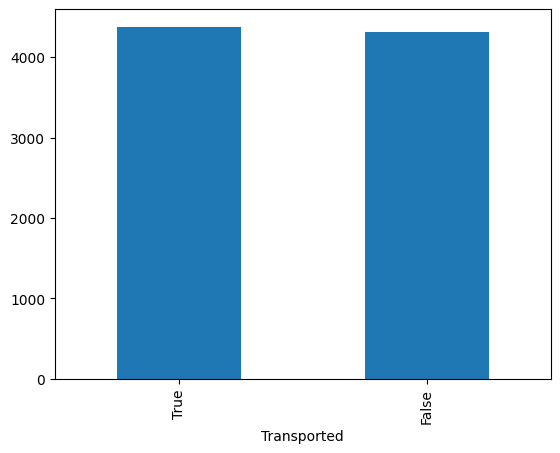

In [8]:
plot_df = X.Transported.value_counts()
plot_df.plot(kind="bar")

The above graph reveals the target is balanced.

# Numerical data distribution
Plot all numerical columns with value counts

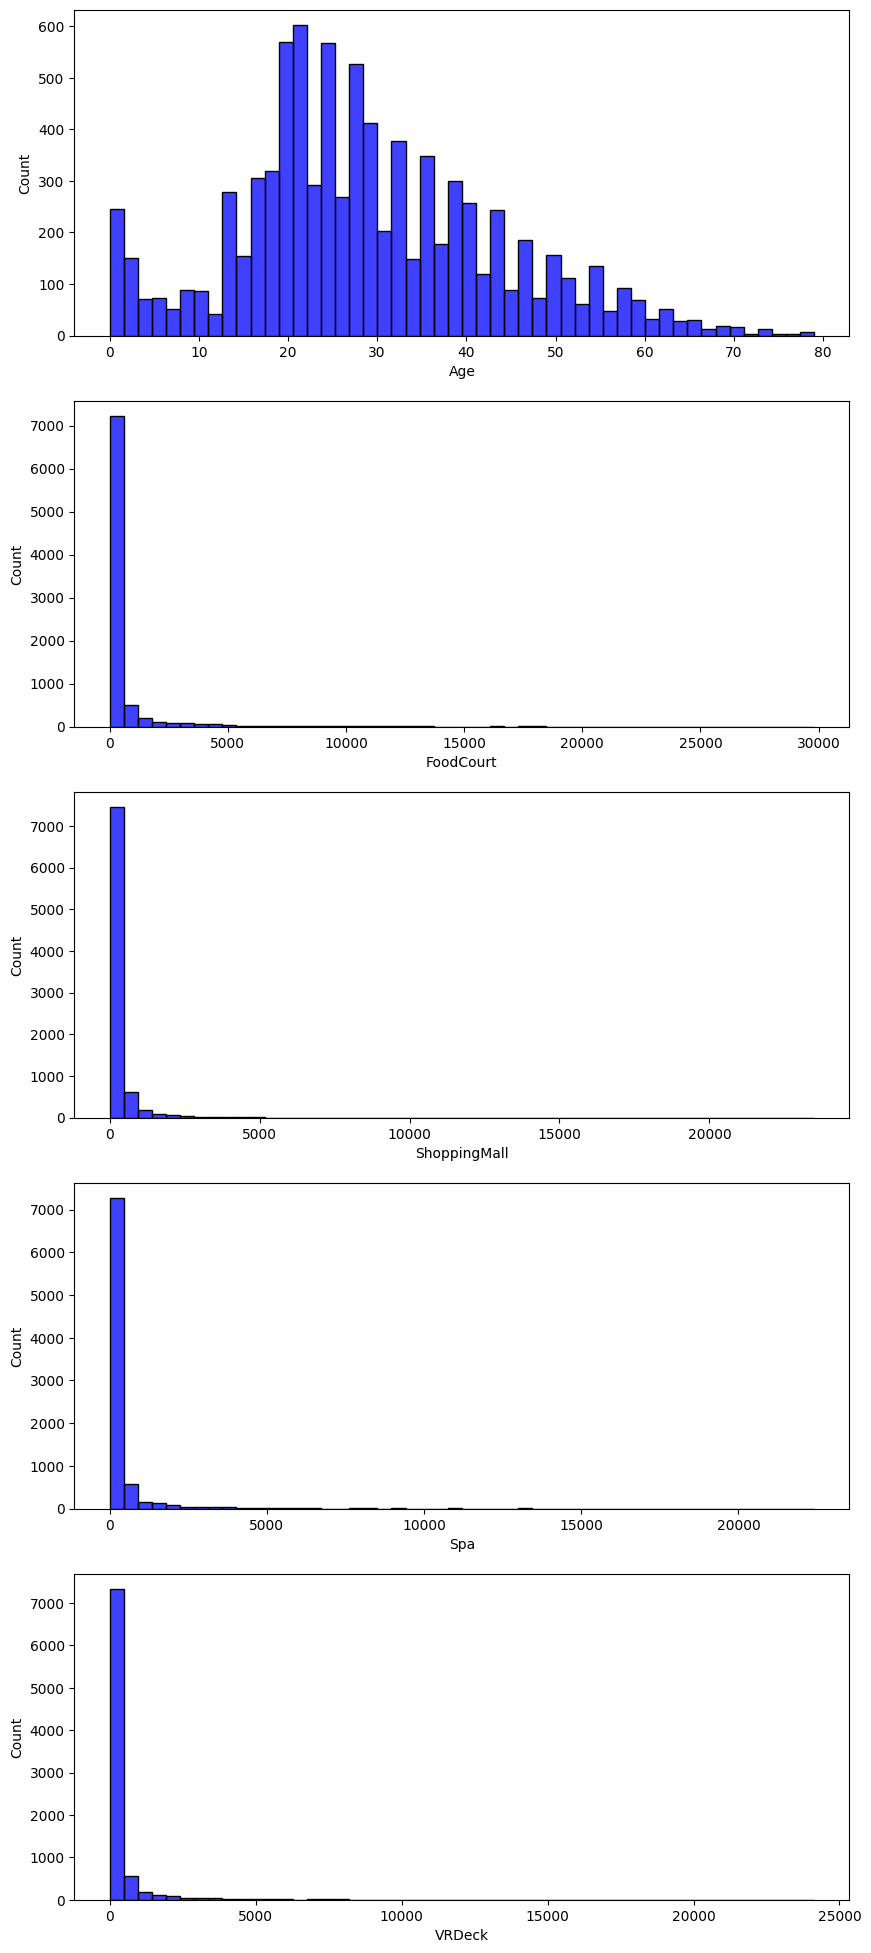

In [9]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(X['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(X['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(X['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(X['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(X['VRDeck'], color='b', bins=50, ax=ax[4]);

# Prepare Data
Dropping unecessary columns, filling missing values with 0, and converting boolean fields to int due to lack of TF-DF support. 

There's no need to encode categorical variables as TF-DF handles them natively.

## Drop extraneous columns

In [10]:
X = X.drop(['PassengerId', 'Name'], axis=1)
# Display updated data
X.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


## Impute missing values with 0
Initially imputed most numeric and boolean columns with 0 as shown in the provided starter project code however amended to only apply this boolean fields so TF-DF can handle the imputation of the numeric features natively as well.

In [11]:
# Show missing value counts
X.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [12]:
X[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = X[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
X.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

## Convert boolean fields to int for TF compatibility

In [13]:
label = "Transported"
X[label] = X[label].astype(int)

In [14]:
X['VIP'] = X['VIP'].astype(int)
X['CryoSleep'] = X['CryoSleep'].astype(int)

## Simple feature engineering
Replacing Cabin with individual features deck, Cabin number, and side. 

Then removing unecessary Cabin feature from dataset.

Will do more local feature engineering after further EDA.

In [15]:
X[["Deck", "Cabin_num", "Side"]] = X["Cabin"].str.split("/", expand=True)

In [16]:
try:
    X = X.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [17]:
# Redisplay updated data
X.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S


## Visualize rest of column distributions

In [18]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck',
       'Cabin_num', 'Side'],
      dtype='object')

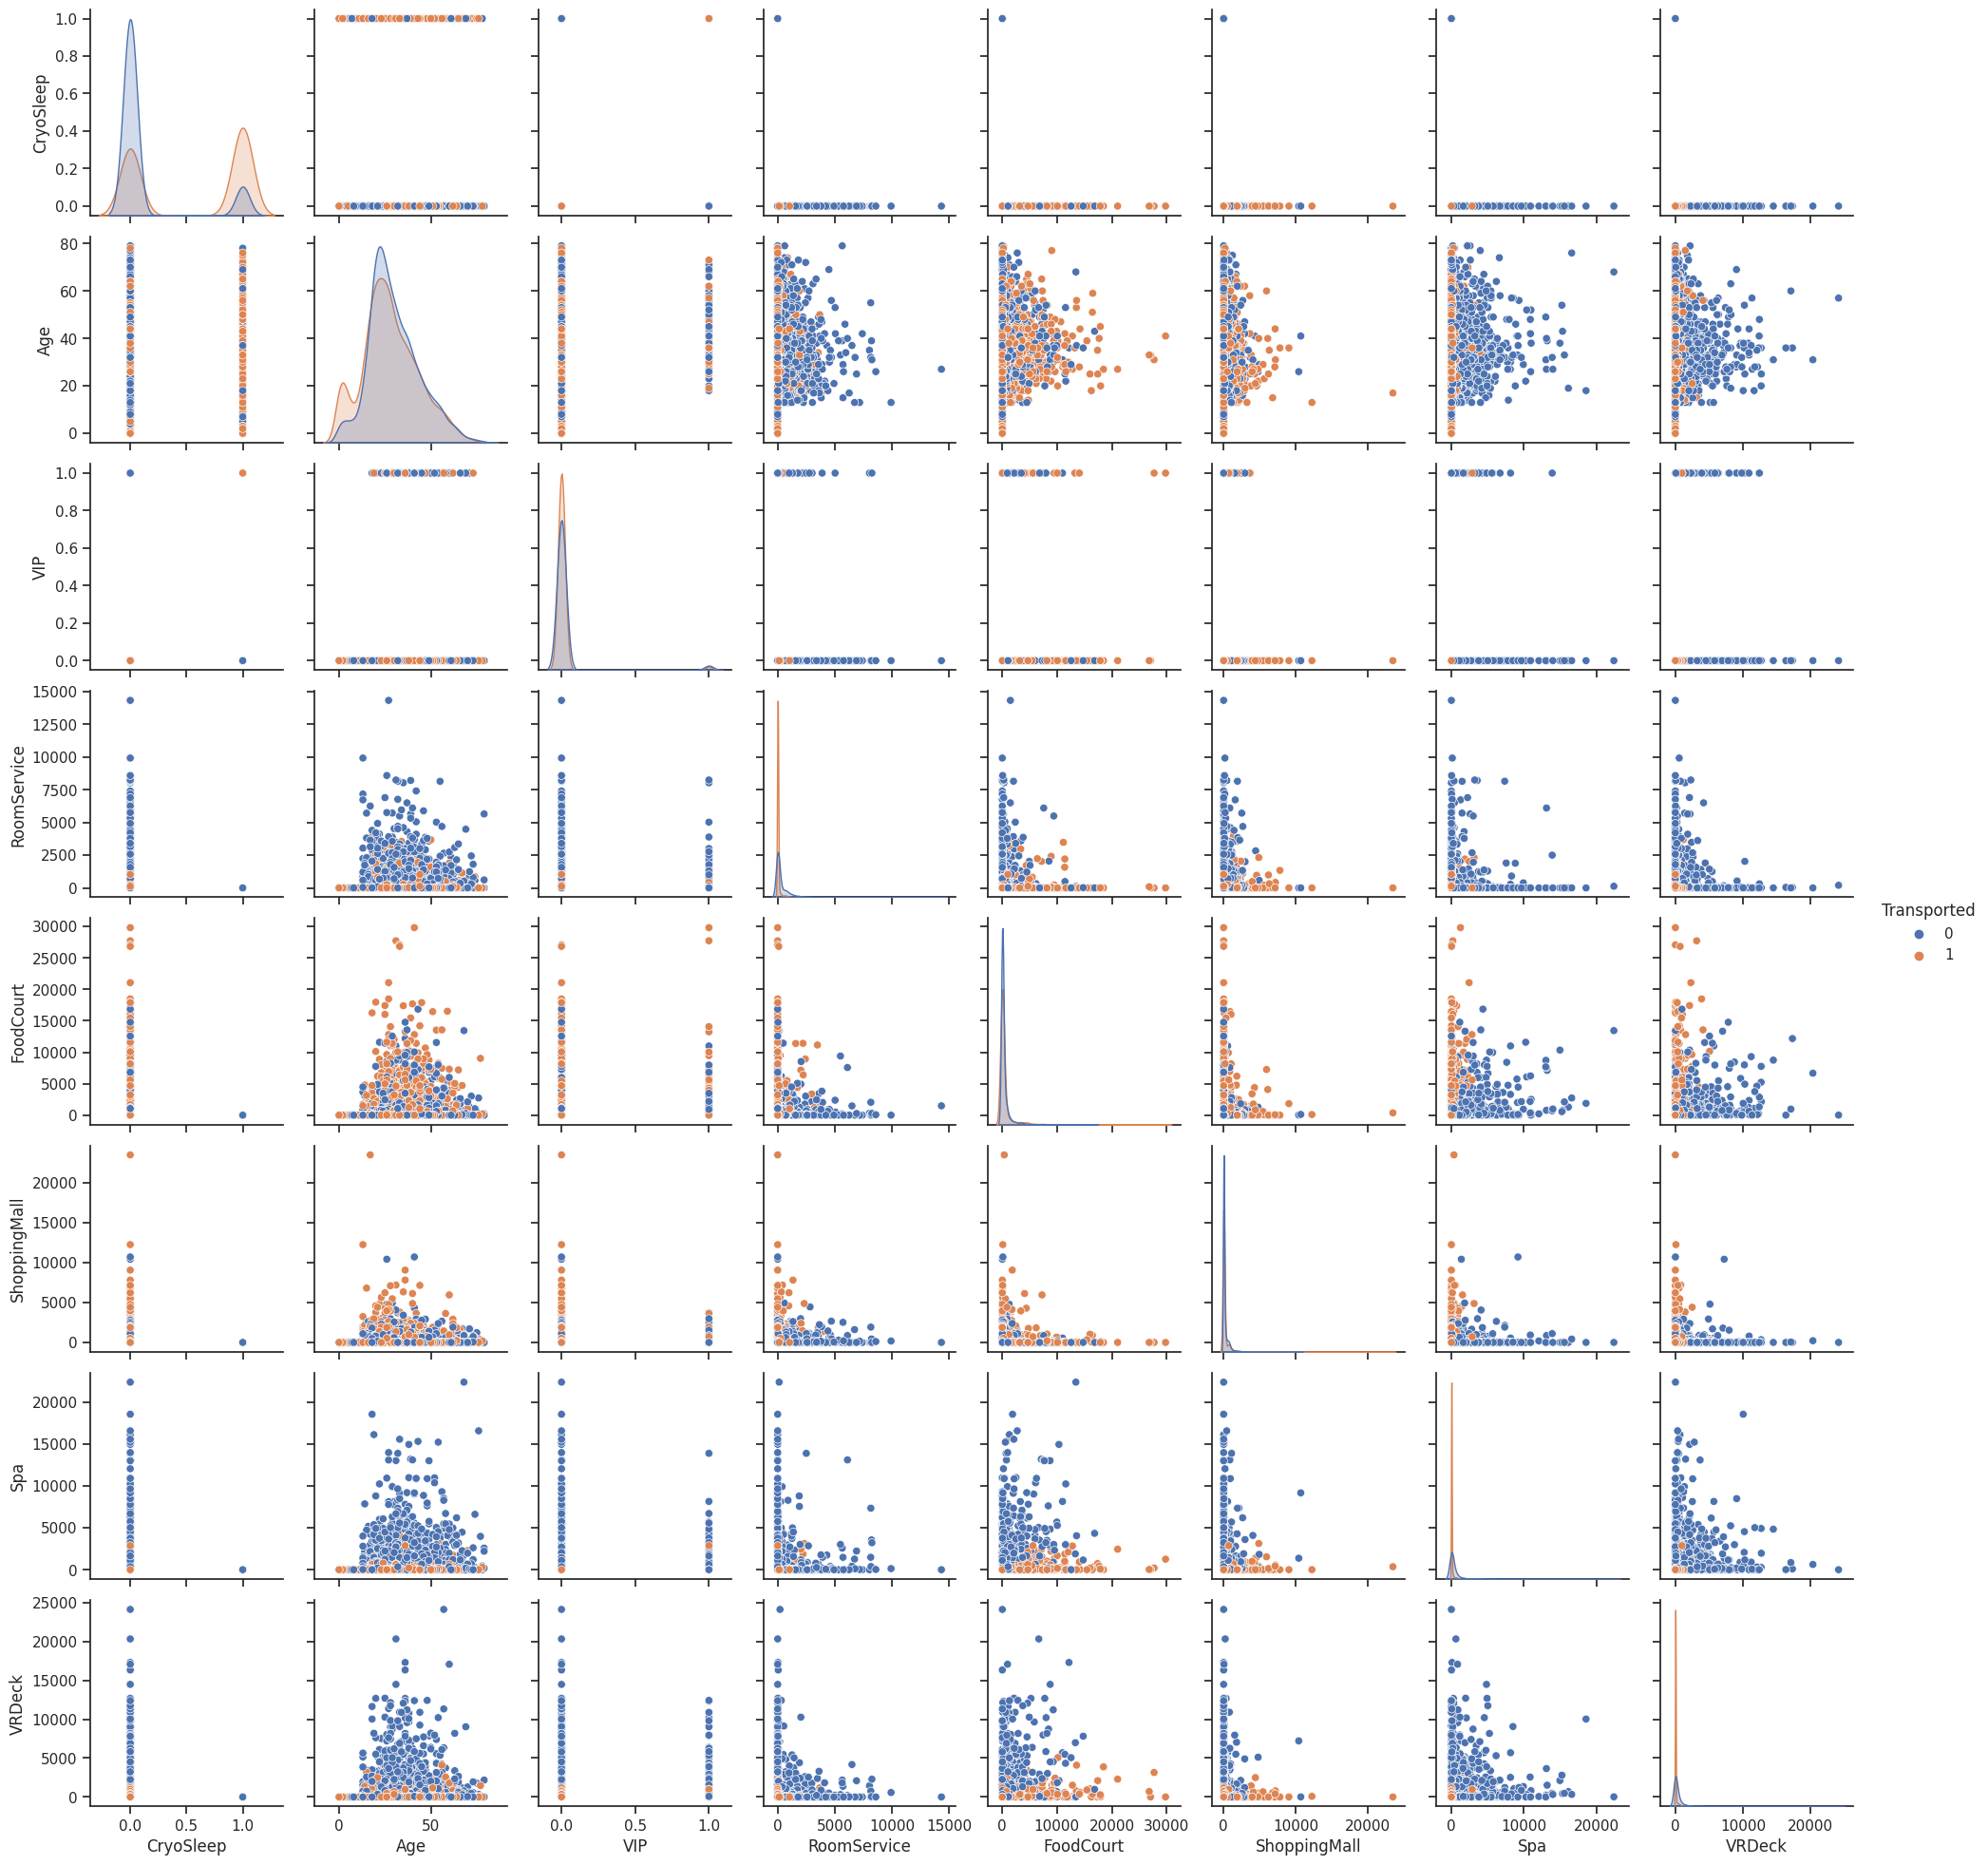

In [19]:
# Visualize numeric training data with Seaborn Scatterplot Matrix
sns.set_theme(style="ticks")
sns.pairplot(X, hue=label)

Not removing outliers as this may affect results. Instead will likely perform some kind of transformation to handle skew.

# Profile with sweetviz to explore variables w.r.t. target

                                             |          | [  0%]   00:00 -> (? left)


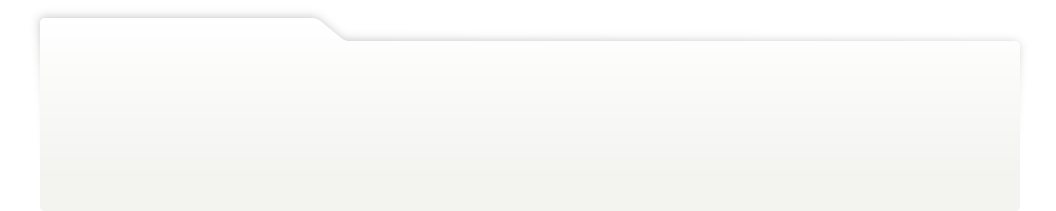
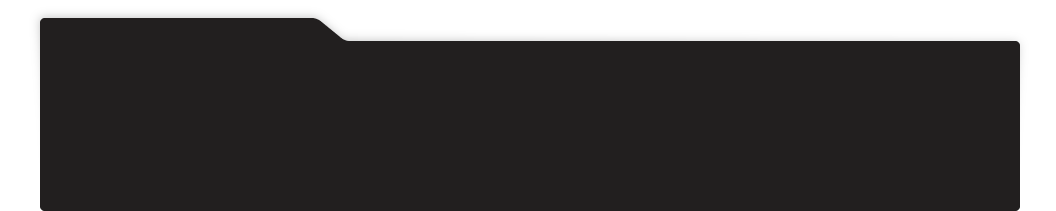
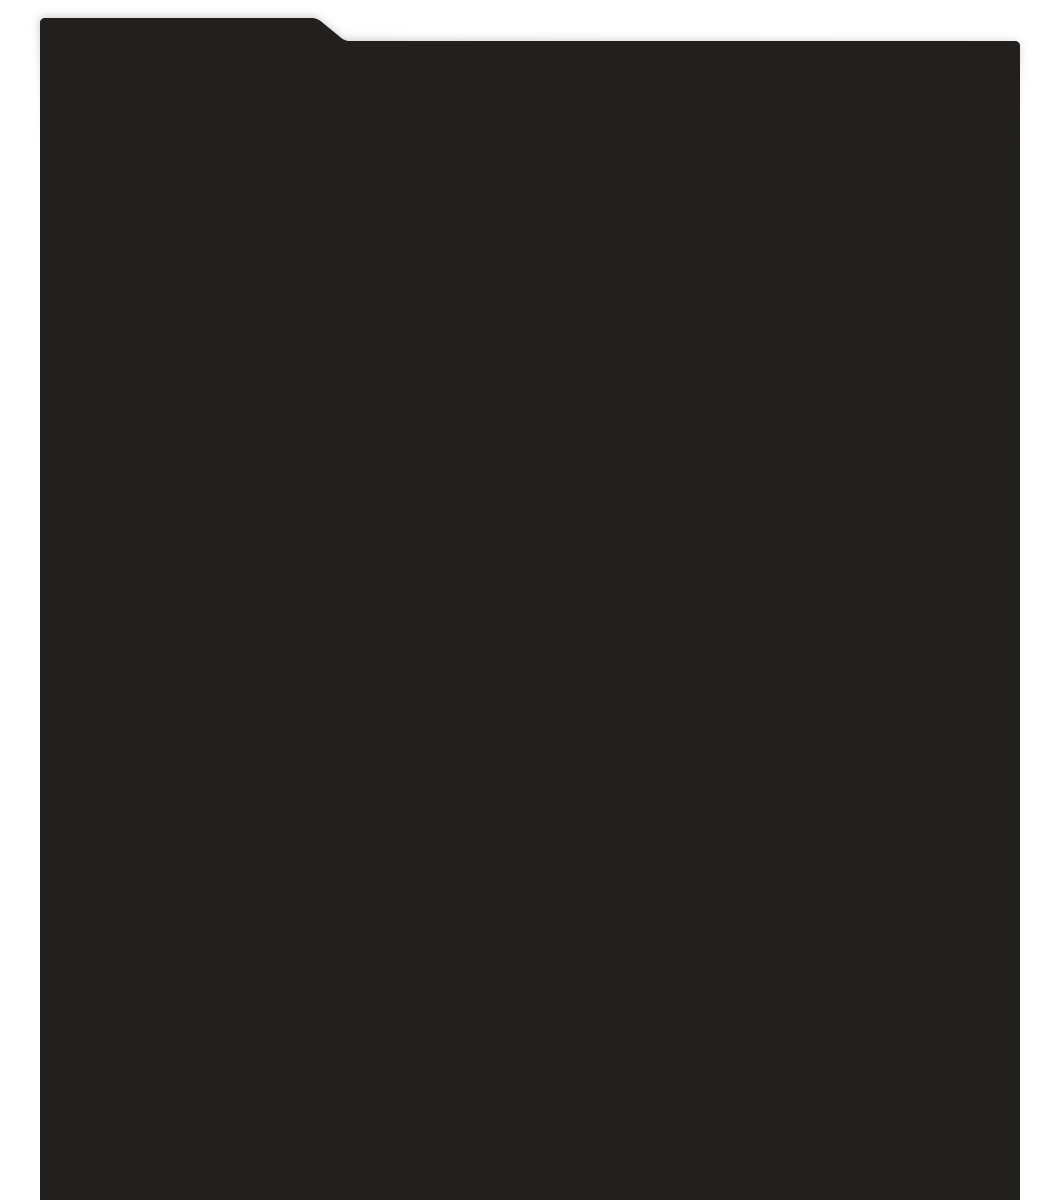
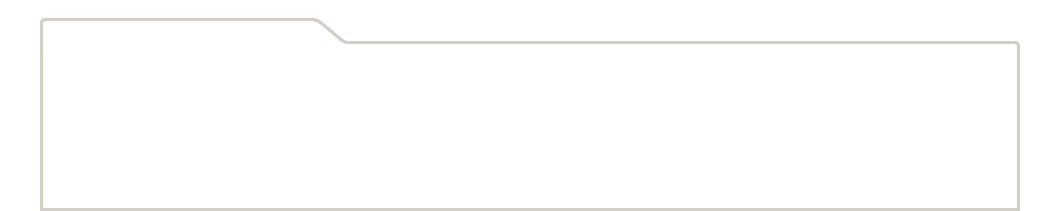
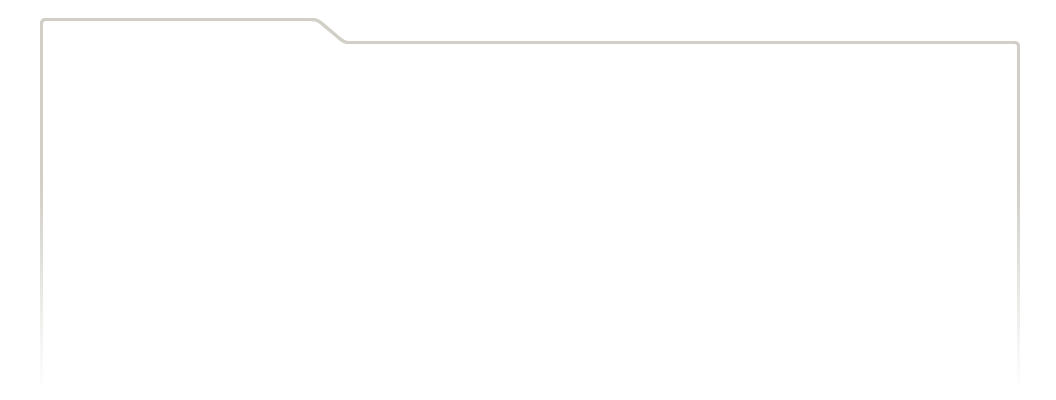
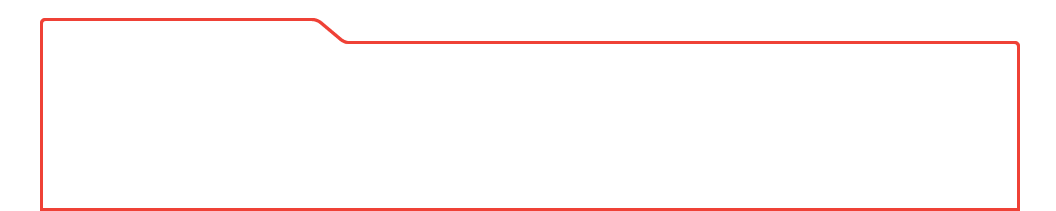
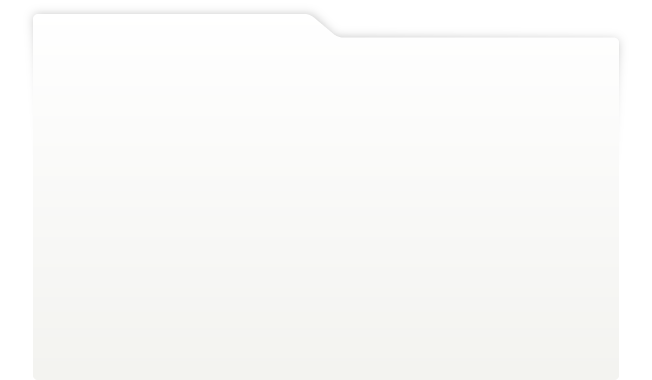
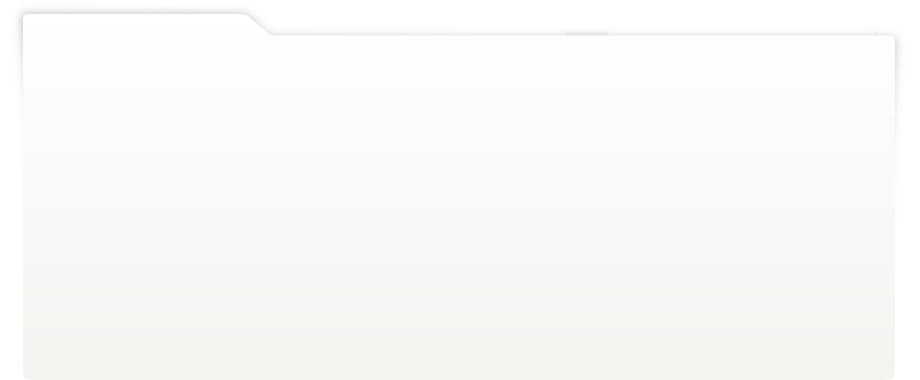
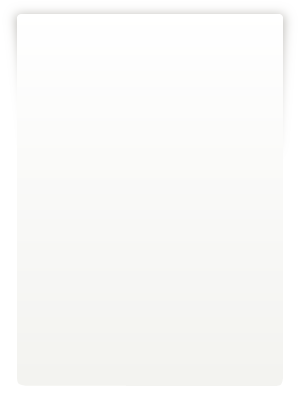
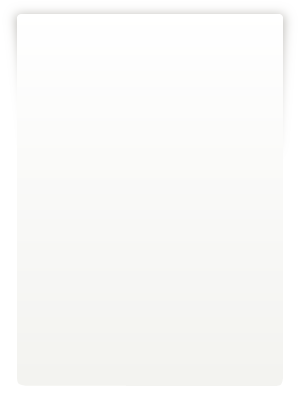
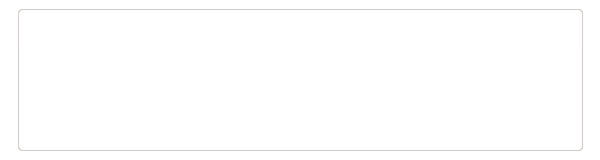
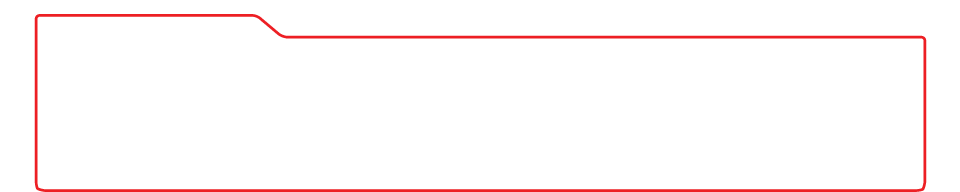
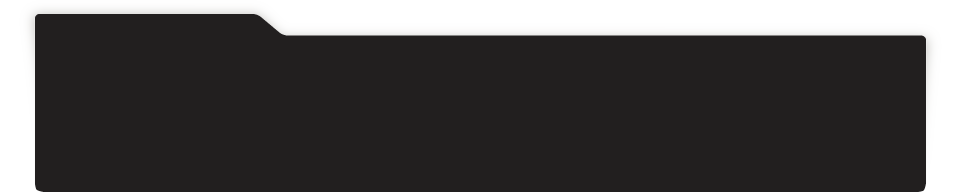
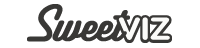
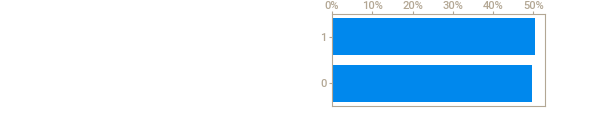
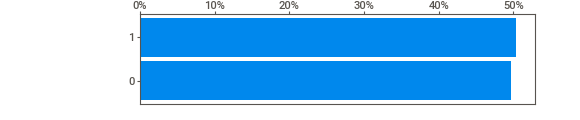
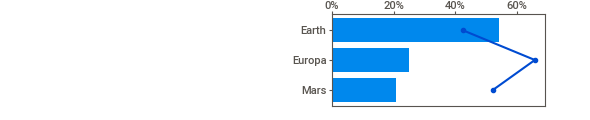
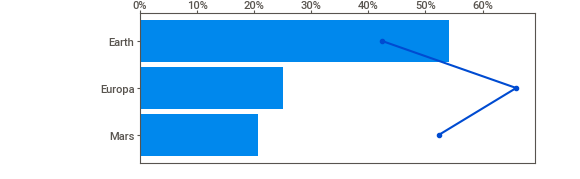
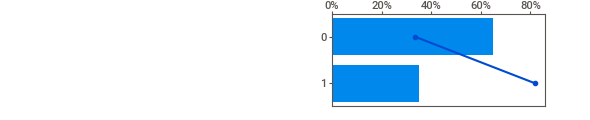
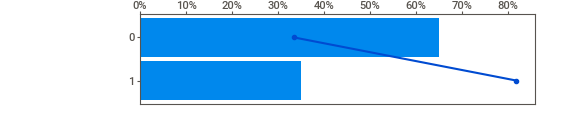
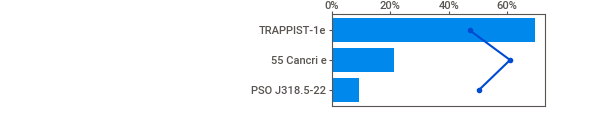
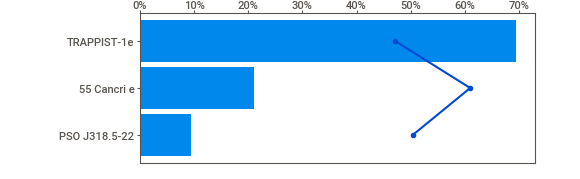
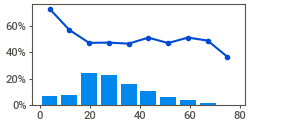
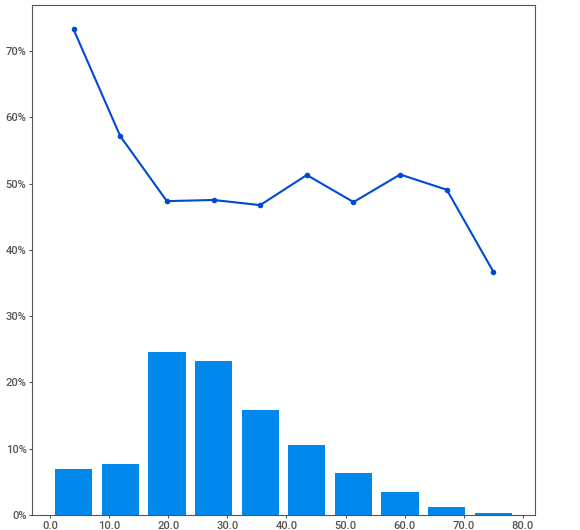
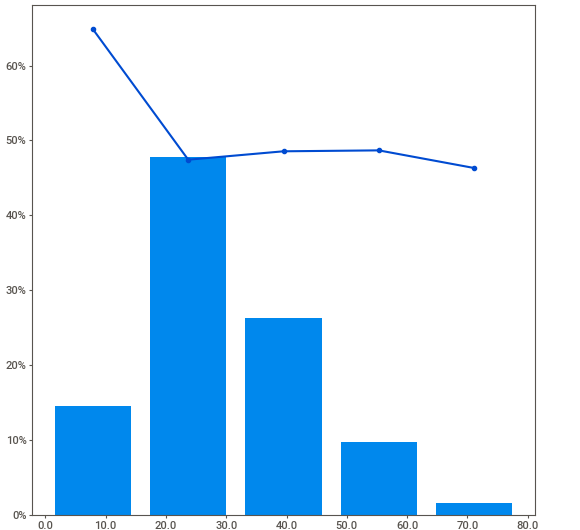
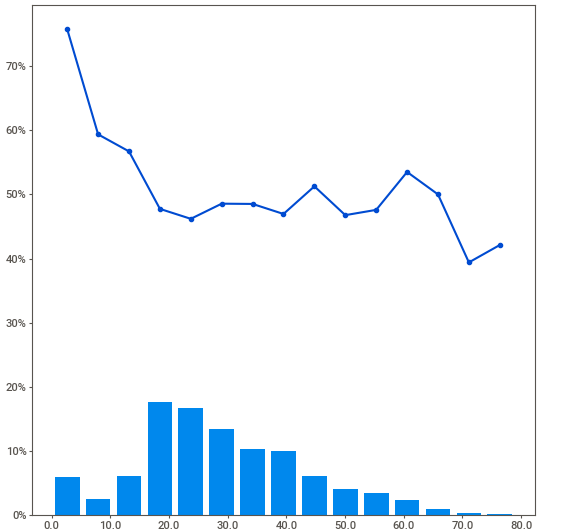
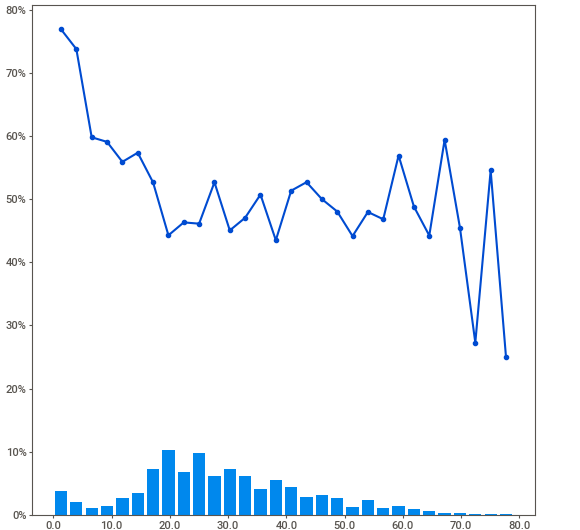
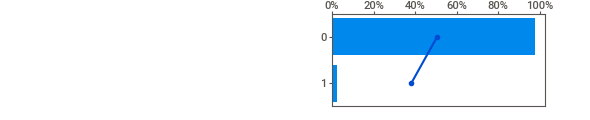
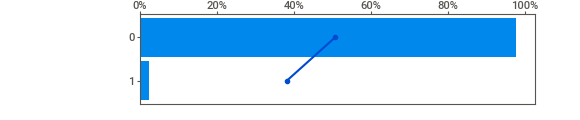
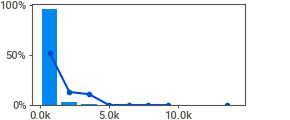
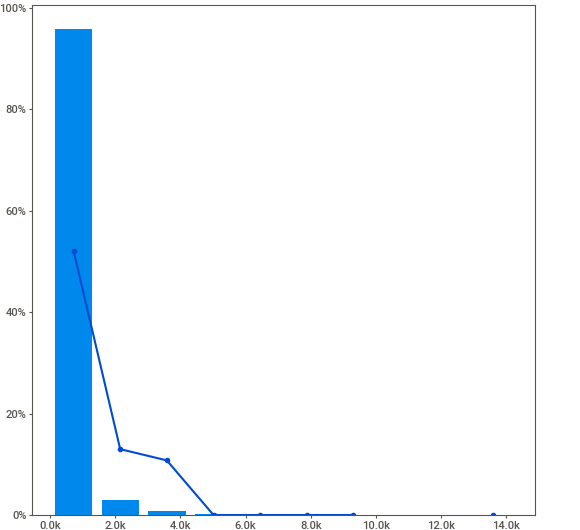
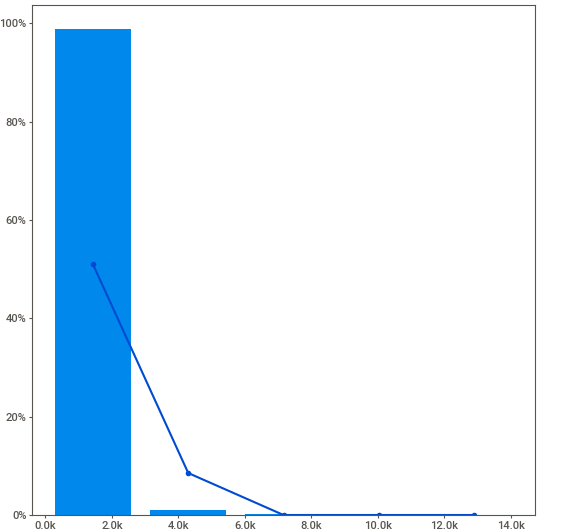
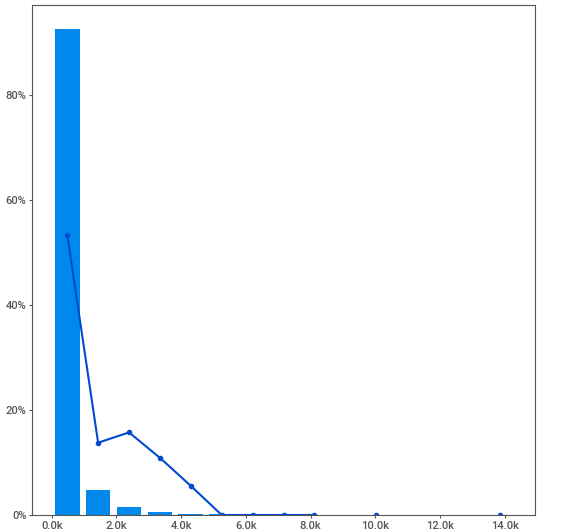
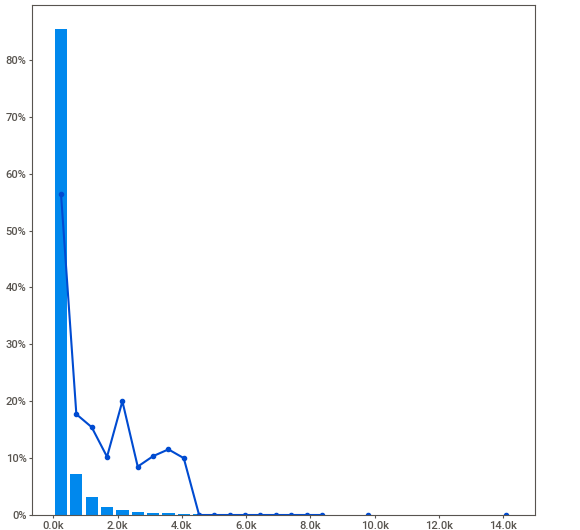
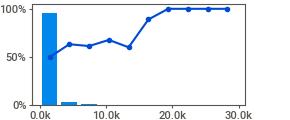
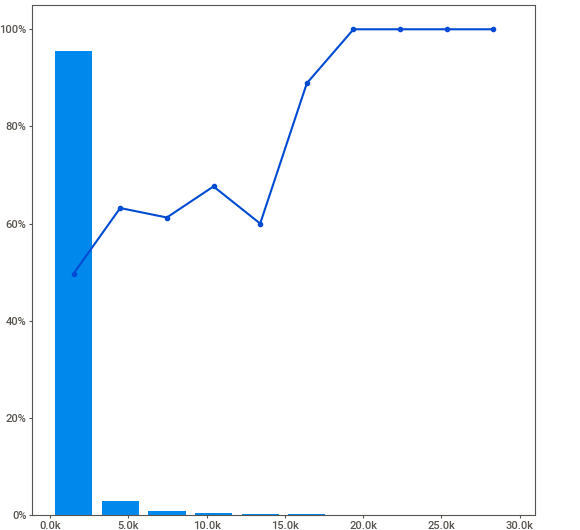
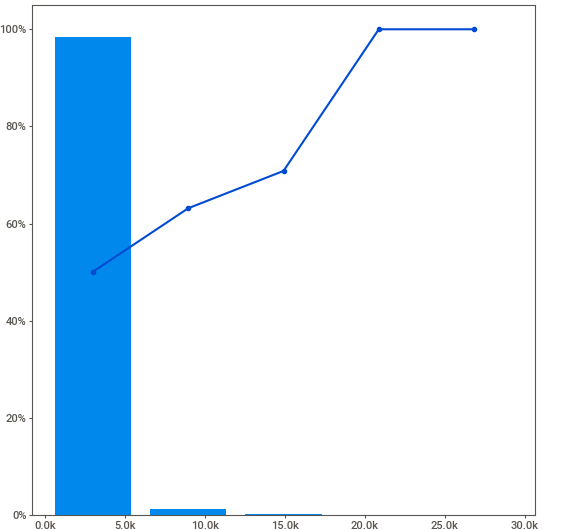
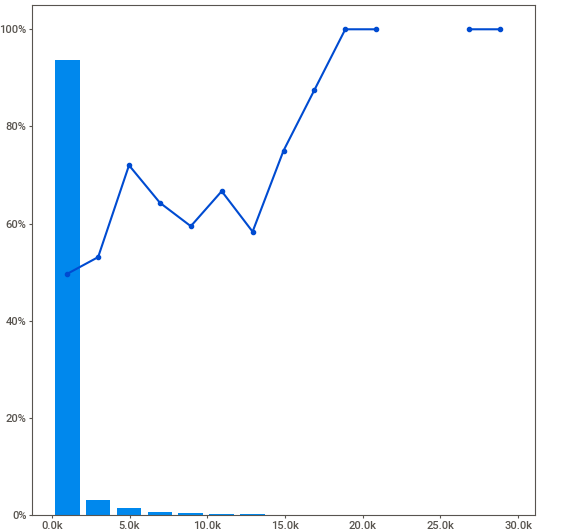
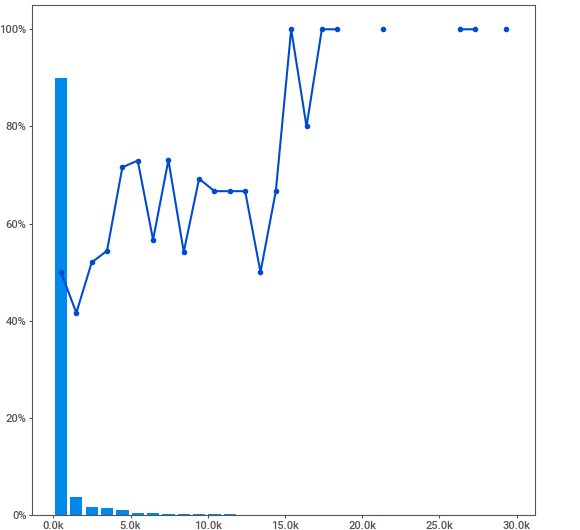
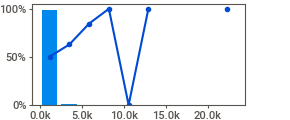
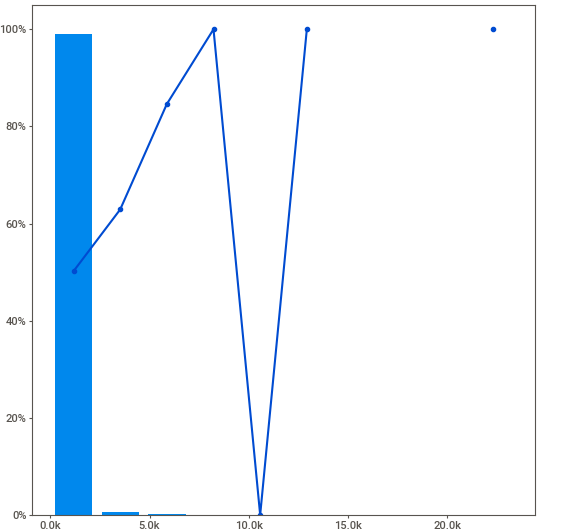
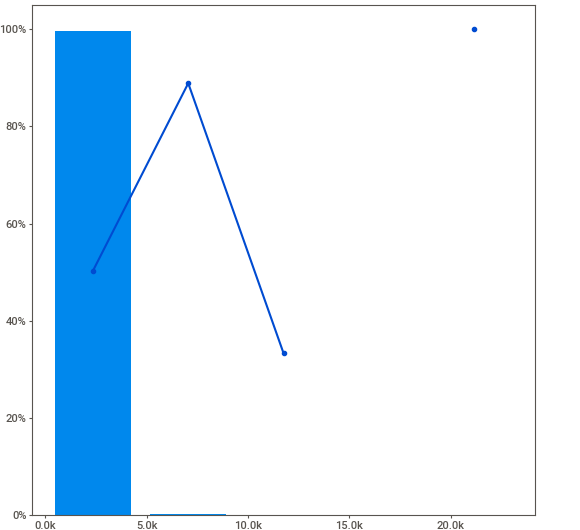
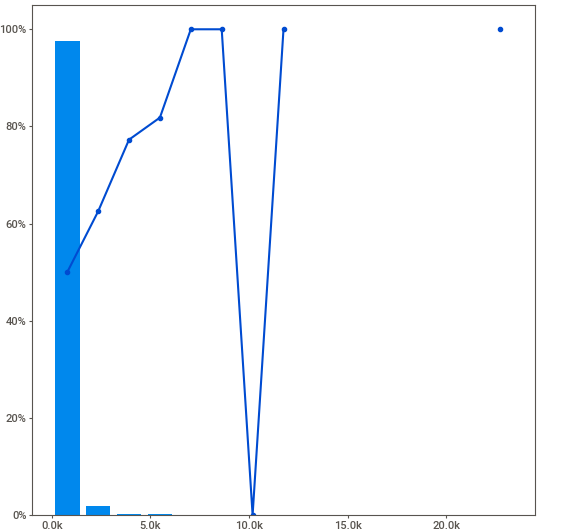
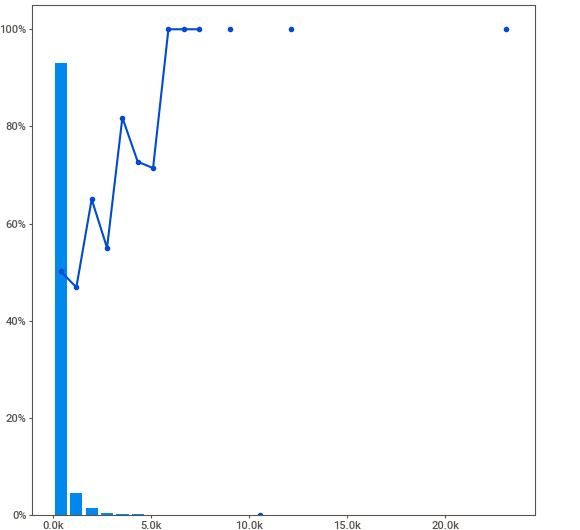
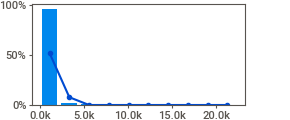
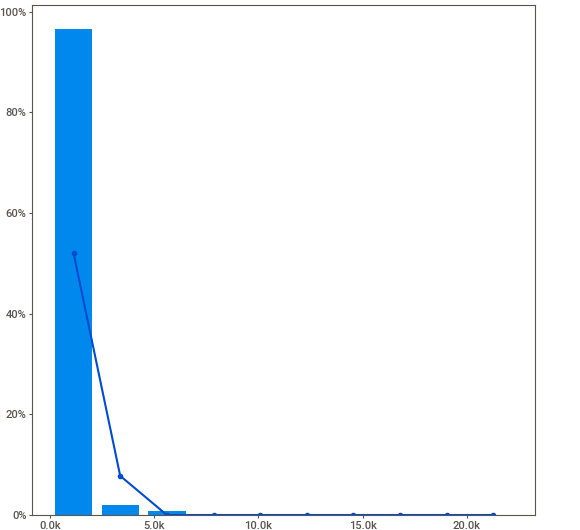
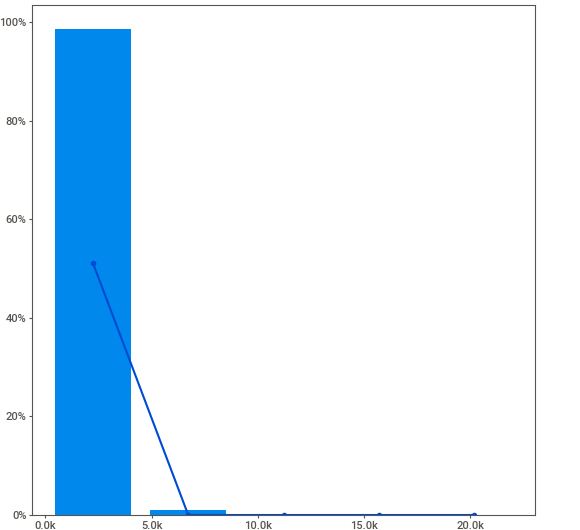
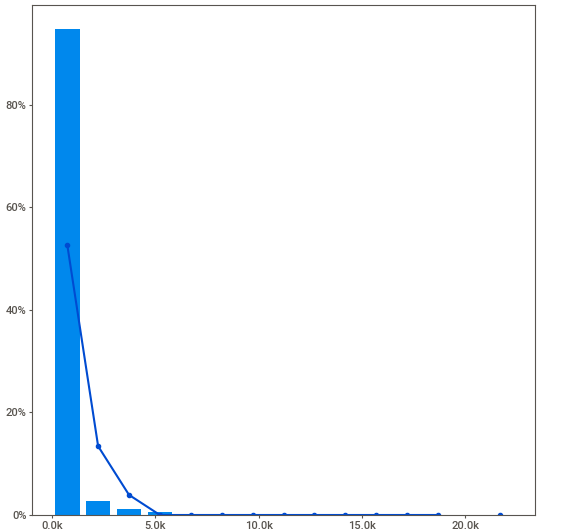
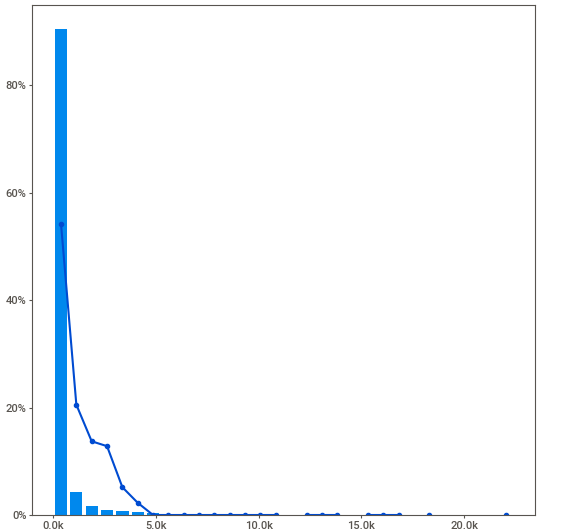
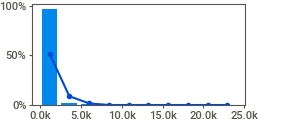
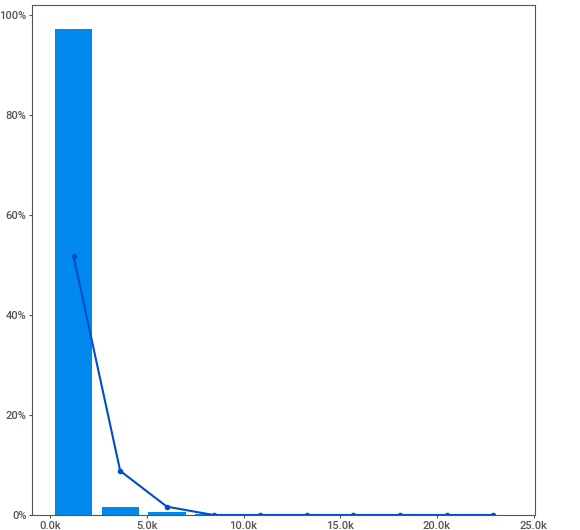
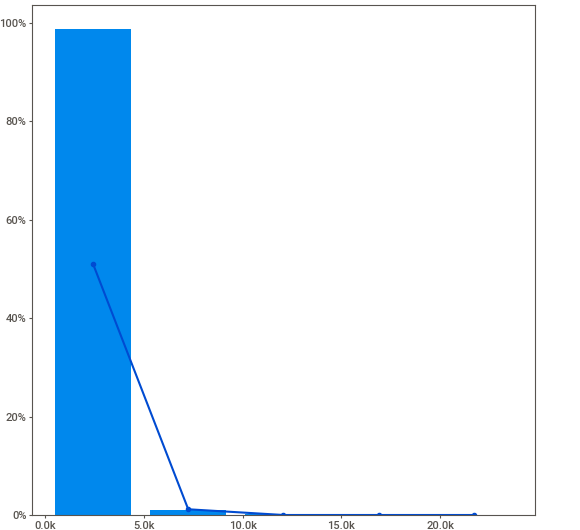
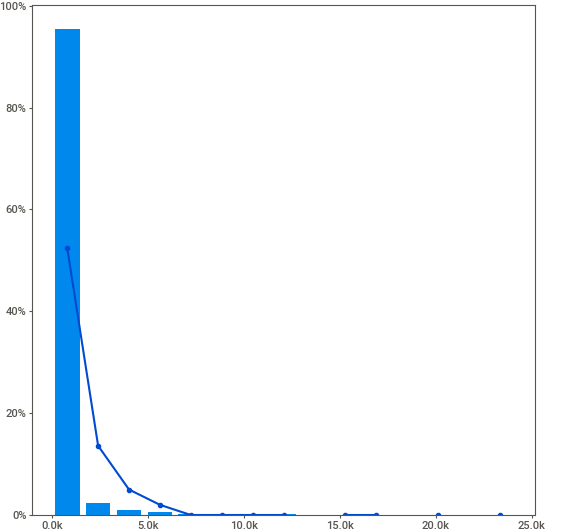
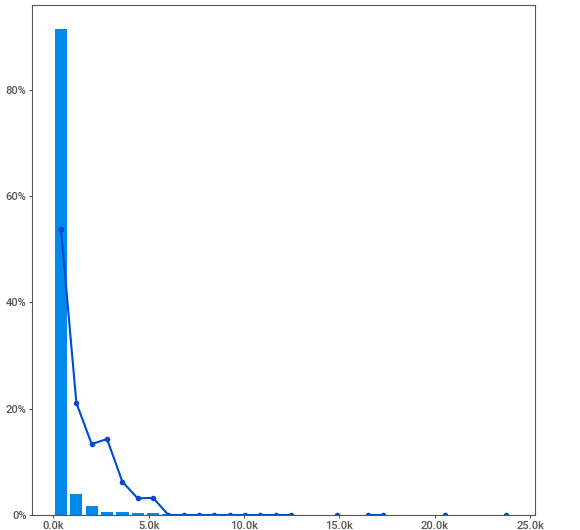
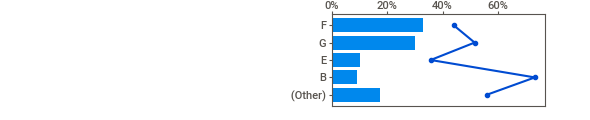
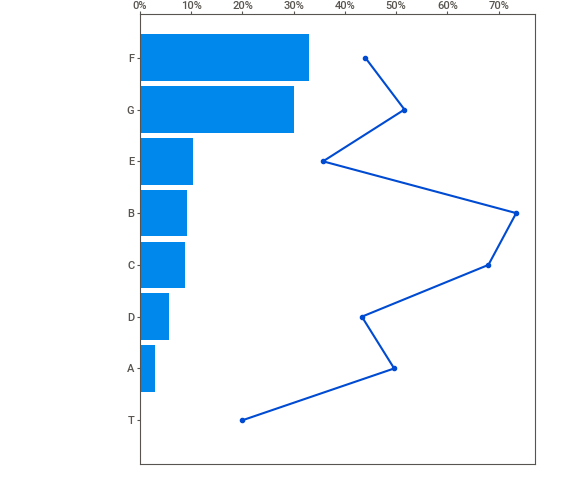
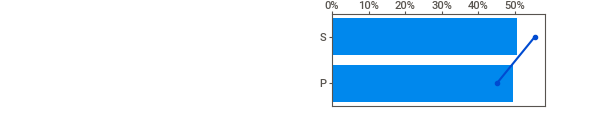
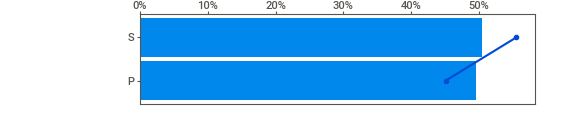
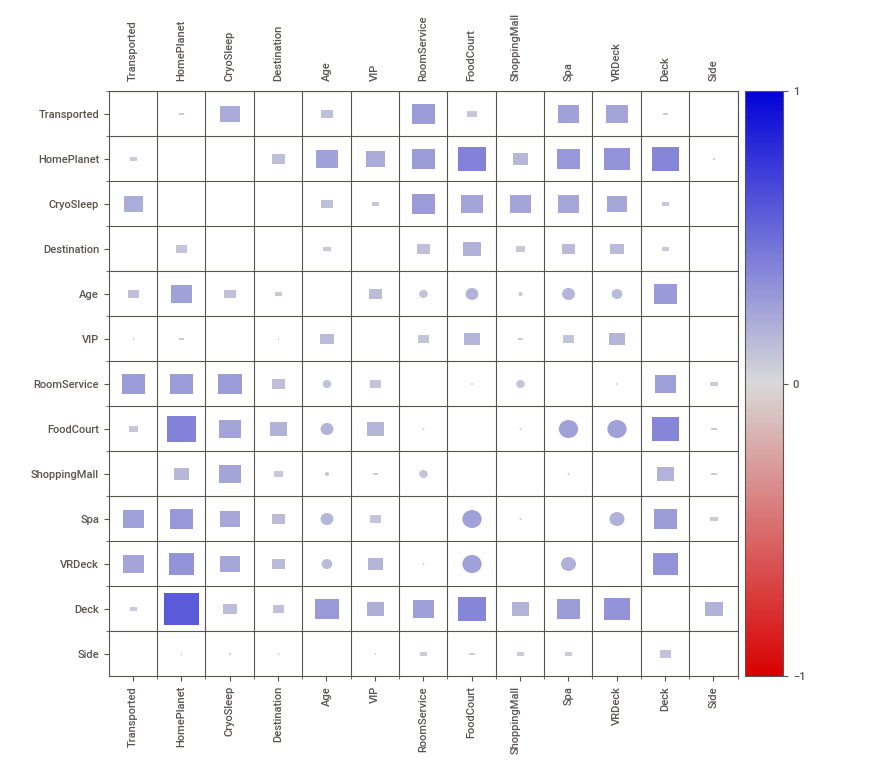
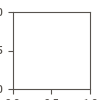

In [20]:
# Also profiling to understand categorical variables better and determine local feature engineering steps
my_report = sv.analyze(X, label)
my_report.show_notebook()

# Using insights from above profiling report to inform the rest of my manual EDA
- Will also inform local feature engineering steps to come.
- TODO: determine which plotting techniques from seaborn to use for each representation of data below.

## Visualizing relationship between Deck, HomePlanet and Age w.r.t. Target
According to the graph for Age, even though the majority of passengers fell within the middle age range (highest of which were 20s and 30s) the probability of getting transported had a negative correlation with Age as in the youngest were most likely to be transported whereas the seniors were least likely. High correlations with Deck and HomePlanet in that order.

## Visualizing relationship between Cryosleep and Luxury Amenities w.r.t. Target
Luxury amenities being VIP status, as well as RoomService, FoodCourt, ShoppingMall, VRDeck costs
Training data shows extremely high correlation between Cryosleep and Transported (82% if in cryo vs only 32% not in cryo) so explore this further as well as w.r.t. other features.

## Visualizing relationship between Destination and Target
Although most passengers (69%) were traveling to TRAPPIST-1e, there was a higher transported rate, of 61%, for those going to 55 Cancri e - which constituted only 21% of passengers. Figure out why this is.

## Visualizing relationships between Deck and Side w.r.t. Target
- Deck shows most passengers on B and C decks were transported vs much lower transported rates for all other decks, even though the majority fo people stayed in F and G decks. 
- Side is balanced, 50/50 split for passengers on Starboard and Port sides, although there is a slightly higher transported rate for S side. 

# Splitting dataset for training and evaluation

In [ ]:
# Splitting 20% of training set into additional validation set before local feature engineering steps
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)

# Making training and validation sets compatible with Tensorflow

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_X, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_X, label=label)